# L10d: Sampling and Training of a Restricted Boltzmann Machine

## Tasks
Before we get started,execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (10 min)__: In this task, we'll take a few minutes to load [the USPS handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database#USPS_database) that our restricted Boltzmann machine will model. These are `16` $\times$ `16` gray-scale images of handwritten numbers.
* __Task 2: What happens in a feedforward and feedback pass (20 min)__?
In this task, let's assume some random values for the parameters $\mathbf{W}$, $\mathbf{a}$ and $\mathbf{b}$ and see what happens when we do a combined _feedforward_ and _feedback_ pass through the restricted Boltzmann machine.
* __Task 3: Let's do a few training steps (20 min)__! In this task, let's do a few training sets and see how this changes the behavior of the restricted Boltzmann machine.

Let's get started!

In [2]:
include("Include.jl"); # Include the required packages and codes from Include.jl

## Task 1: Setup, Data, Constants
In this task, we'll take a few minutes to load [the USPS handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database#USPS_database) that our restricted Boltzmann machine will model.

However, before we load the dataset, let's set some constants we'll use in the lab. Please see the comment next to the value for a description of the constant, its permissible values, etc.

In [4]:
number_of_images_to_explore = 200; # how many images do we want to play with?
number_of_rows = 16;
number_of_cols = 16;
number_of_pixels = number_of_rows*number_of_cols;
number_of_visible_nodes = number_of_pixels;
number_of_hidden_nodes = 4*number_of_pixels;
β = 0.1; # system (inverse) temperature 
number_of_internal_steps = 100; # how many steps do we take in the feedforward + feedback passes?
η = 0.01; # learning rate

__Load the data__. Let's load [the `usps-bad-labels.data` file](data/usps-bad-labels.data), transform the data to the `{-1,1}` scale, and then return this scaled data to the caller in the `X::Array{Int,2}` array, where the images are encoded in the columns of the array.
* _What is in the `X` array_? Each column of the `X::Array{Int,2}` array holds one of the `7291` handwritten images. Each row is a pixel value; a total of `256` pixels per image.
* _What else are we returning_? We also return the `raw_data_dictionary::Dict{Int64, Vector{Float64}}` dictionary that holds the raw (untransformed) data vectors for each image. However, we do not return the label as these were _wrong_. A shocking turn of events!!. I felt betrayed by the internet.

In [6]:
X, raw_data_dictionary = let

    # load the 
    (labels, raw_data_dictionary) = joinpath(_PATH_TO_DATA, "usps-bad-labels.data") |> p -> parser(p);

    # get the number of records -
    number_of_records = length(labels);
    X = Array{Int,2}(undef, number_of_pixels, number_of_records);

    for i ∈ 1:number_of_records
        record = raw_data_dictionary[i];
        for k ∈ 1:number_of_pixels
            if (record[k] ≤ 0.0)
                X[k,i] = -1;
            else
                X[k,i] = 1;
            end
        end
    end

    X[:,1:number_of_images_to_explore], raw_data_dictionary
end;

In [7]:
raw_data_dictionary

Dict{Int64, Vector{Float64}} with 7291 entries:
  4986 => [-1.0, -1.0, -1.0, -1.0, -0.99988, -0.990341, -0.845641, -0.377537, -…
  4700 => [-0.999959, -0.996451, -0.938356, -0.679003, -0.195987, 0.219518, 0.2…
  4576 => [-1.0, -1.0, -1.0, -1.0, -0.999971, -0.998356, -0.976414, -0.911377, …
  7144 => [-1.0, -1.0, -1.0, -0.999996, -0.999945, -0.99965, -0.986294, -0.7905…
  6073 => [-0.999828, -0.985106, -0.769292, -0.190479, 0.133481, 0.027313, -0.1…
  2288 => [-1.0, -1.0, -1.0, -0.999942, -0.994807, -0.906057, -0.481336, 0.1212…
  1703 => [-1.0, -1.0, -0.999929, -0.993736, -0.893689, -0.492704, 0.058186, 0.…
  1956 => [-1.0, -1.0, -1.0, -0.999999, -0.999801, -0.987675, -0.816333, -0.292…
  2350 => [-0.999998, -0.999922, -0.99864, -0.987528, -0.917924, -0.708757, -0.…
  5975 => [-0.931519, -0.623818, -0.084242, 0.201256, 0.12177, -0.090782, -0.28…
  3406 => [-1.0, -1.0, -0.999996, -0.999628, -0.990799, -0.90909, -0.618184, -0…
  2841 => [-0.99531, -0.956031, -0.846924, -0.681021, -0.4341

__Probability distribution of the data__. In the code below, we want to be able to sample the data, for example, generate mini-batches of data to estimate the model parameters. However, we cannot compute the partition function even though our data vectors are relatively small, i.e., `16^2 = 256` pixels. 
* _How can we solve this problem_? Let's compute the probability of observing a pattern in the _data that we do have_, and use this to approximate $P(\mathbf{x})_{\text{data}}$. We'll compare each pattern to every other by computing a _dissimilarity score_. If the dissimilarity is below a threshold, the patterns are assumed to be similar (we increment a `counter`).
* We compute an approximate probability of seeing _similar_ patterns from the `counter` values [using the `softmax(...)` method](src/Compute.jl) and use this to initialize [a `Categorical` distribution exported by the `Distributions.jl` package](https://juliastats.org/Distributions.jl/latest/univariate/#Distributions.Categorical).
* We save the categorical distribution in the `data_distribution::Categorical{Float64, Vector{Float64}}` variable.

In [9]:
(data_distribution,p) = let

    # initialize -
    number_of_samples = size(X, 2); # how many turns do we have
    θ = Array{Float64,1}(undef, number_of_samples);

    for i ∈ 1:number_of_samples
        sᵢ = X[:,i]; # get the ith pixel pattern

        counter = 0;
        for j ∈ 1:number_of_samples
            sⱼ = X[:,j]; # get the jth pixel pattern

            # compute the difference -
            d = (1/(4*number_of_pixels))*sum((sᵢ .- sⱼ).^2);            
            if (d ≤ 0.20)
                counter += 1;
            end
        end
        θ[i] = counter/number_of_samples
    end

    # initialize categorical distribution w/p -
    p = softmax(θ);
    data_distribution = Categorical(p);

    data_distribution,p    
end;

What does our data distribution look like?

i = 153


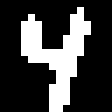

In [84]:
i = rand(data_distribution)
@show i
decode(X[:,i], number_of_rows = number_of_rows, number_of_cols = number_of_cols) |> img -> Gray.(img)

## Task 2: What happens in a feedforward and feedback pass?
In this task, let's assume some random values for the parameters $\mathbf{W}$, $\mathbf{a}$ and $\mathbf{b}$ and see what happens when we do a combined _feedforward_ and _feedback_ pass through the restricted Boltzmann machine.

First, let's build a model. We'll create an instance of [the `MyRestrictedBoltzmannMachineModel` type](src/Types.jl) with random values for the $\mathbf{W}$, $\mathbf{a}$ and $\mathbf{b}$  parameters.
* _What is `randn(...)`_? The [`randn(...)` method](https://docs.julialang.org/en/v1/stdlib/Random/#Base.randn) generates normally distributed random numbers with mean `0` and standard deviation `1`. 

In [13]:
model = let 
    
    # initialize some random weights and biases
    W = 2*randn(number_of_visible_nodes, number_of_hidden_nodes);
    a = randn(number_of_visible_nodes)
    b = randn(number_of_hidden_nodes);

    # next, build the model -
    model = build(MyRestrictedBoltzmannMachineModel, (
        W = W,
        a = a,
        b = b,
    ));

    # return -
    model;
end;

__Sample__. We've implemented the restricted Boltzmann machine's feedforward and feedback passes in [the `simulate(...)` method](src/Compute.jl).
* _What is going on_? Break up into groups and describe to each other what is going on in the feedforward and feedback passes of the RBM. The code is in the [Compute.jl](src/Compute.jl) file of you want to check it out.

In [86]:
(vₒ,v, h) = let

    # draw a random index from the data distribution
    i = rand(data_distribution);
    
    vₒ = X[:,i]; # initial visible layer values
    (v,h) = simulate(model, vₒ, T = number_of_internal_steps, β = β);

    (vₒ,v,h)
end;

In [96]:
h

1024×100 Matrix{Int64}:
  1  -1  -1  -1   1  -1  -1   1  -1  …  -1  -1  -1   1  -1   1   1  -1  -1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
 -1   1   1  -1  -1  -1  -1   1   1      1  -1   1   1  -1   1  -1  -1   1
  1   1   1   1   1   1   1   1  -1      1   1   1   1   1   1   1   1   1
  1  -1  -1  -1  -1  -1  -1  -1  -1     -1   1  -1   1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1   1  -1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1   1      1  -1  -1  -1  -1  -1  -1  -1  -1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1   1  -1  -1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
  1  -1  -1   1  -1   1   1   1  -1      1   1   1  -1  -1  -1   1   1   1
  1   1   1   1   1   1   1   1  -1      1   1   1   1   1   1   1   1   1
 

__What are we giving the RBM__? We specify the initial condition for the _visible layer_ by drawing a sample $\mathbf{v}_{\circ}\sim{P}(\mathbf{x})_{\text{data}}$ using the data distribution $P(\mathbf{x})_{\text{data}}$ that we estimated in `task 1`. What is that sample?

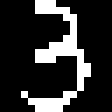

In [88]:
decode(vₒ, number_of_rows = number_of_rows, number_of_cols = number_of_cols) |> img -> Gray.(img)

__After a single pass, what do we see__? We gave $\mathbf{v}_{\circ}$, and then did `number_of_internal_steps::Int` number of internal steps, i.e., $n$-feedforward steps which generated $\mathbf{h}_{1},\dots,\mathbf{h}_{n}$. From that sequence, we grab the last value, and then we generate $\mathbf{v}_{1},\dots,\mathbf{v}_{n}$ feedback steps _starting_ from $\mathbf{h}_{n}$.

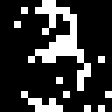

Turn index = 100


In [90]:
let
    do_I_want_to_see_a_movie = true; # set this flag to watch the frames
    if (do_I_want_to_see_a_movie == true)
        for i ∈ 1:number_of_internal_steps
            img = decode(v[:,i], number_of_rows = number_of_rows, number_of_cols = number_of_cols);
            display(Gray.(img))
            println("Turn index = $(i)")
            IJulia.clear_output(true) # may not work in VSCode?
            sleep(0.1) # add some delay
        end
    end
end

__What does the hidden layer look like?__ A strange (and frustrating) thing about deep learning and neural networks in general is the lack of interpretability. Let's visualize how the _hidden_ layer is changing during the $n$ feedforward steps.

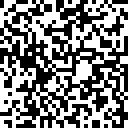

Turn index = 100


In [92]:
let

    # initialize -
    number_of_rows = sqrt(number_of_hidden_nodes) |> x-> round(Int,x)
    number_of_cols = sqrt(number_of_hidden_nodes) |> x-> round(Int,x)

    do_I_want_to_see_a_movie = true; # set this flag to watch the frames
    if (do_I_want_to_see_a_movie == true)
        for i ∈ 1:number_of_internal_steps
            img = decode(h[:,i], number_of_rows = number_of_rows, number_of_cols = number_of_cols);
            display(Gray.(img))
            println("Turn index = $(i)")
            IJulia.clear_output(true) # may not work in VSCode?
            sleep(0.1) # add some delay
        end
    end
end

## Task 3: Let's do a few training steps
In this task, let's do a few training sets and see how this changes the behavior of the restricted Boltzmann machine. 
* _How does the training work_? The training method for the RBM is known as Contrastive Divergence (CD). Let's walk through this [description of the CD algorithm](https://ml-lectures.org/docs/unsupervised_learning/ml_unsupervised-1.html#training-an-rbm).

We've implemented [the CD algorithm](https://ml-lectures.org/docs/unsupervised_learning/ml_unsupervised-1.html#training-an-rbm) in [the `learn(...)` method](src/Compute.jl). 
* The [`learn(...)` method](src/Compute.jl) takes a `model::MyRestrictedBoltzmannMachineModel` instance, the image dataset `X::Array{Int,2}` array, our approximate value for $P(\mathbf{x})_{\text{data}}$, the system (inverse) temperature `β::Float64`, the learning rate `η::Float64` and some other control parameters, e.g., `maxnumberofiterations::Int` which is the maximum number of iterations we want the training to go for.
* This method returns a new `MyRestrictedBoltzmannMachineModel` with the updated parameters.

In [133]:
newmodel = let

    # initialize -
    do_I_want_to_train_the_model = true;
    newmodel = nothing;

    if (do_I_want_to_train_the_model == true)
        newmodel = learn(model,X,data_distribution, maxnumberofiterations = 20,
            T = number_of_internal_steps, β = β, η = η, verbose = true, batchsize = 10); # do a few training steps, and let's see what is going o
    else
        newmodel = model; # skip the training, return the old model 
    end

    # return -
    newmodel;
end;

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20


__After a single pass of the trained model, what do we see__? We gave $\bar{\mathbf{v}}_{\circ}$, and then did `number_of_internal_steps::Int` number of internal steps, i.e., $n$-feedforward steps which generated $\bar{\mathbf{h}}_{1},\dots,\bar{\mathbf{h}}_{n}$, and then we generated $\bar{\mathbf{v}}_{1},\dots,\bar{\mathbf{v}}_{n}$ feedback steps _starting_ from $\bar{\mathbf{h}}_{n}$.

In [127]:
v̄ₒ, v̄, h̄ = let

    # draw a random index from the data distribution
    i = rand(data_distribution);
    vₒ = copy(X[:,i]); # initial visible layer values

    # let's make this a little harder -
    for j ∈ eachindex(vₒ)
        if (rand() ≤ 0.15)
            vₒ[j] = -1;
        end
    end

    # uncomment me to see the image -
    # img = decode(vₒ, number_of_rows = number_of_rows, number_of_cols = number_of_cols);
    # display(Gray.(img))
    
    # run the simulation -
    (v,h) = simulate(newmodel, vₒ, T = number_of_internal_steps, β = β);

    # return -
    vₒ, v, h
end;

__What are we giving the updated RBM__? We specify the initial condition for the _visible layer_ by drawing a sample $\mathbf{v}_{\circ}\sim{P}(\mathbf{x})_{\text{data}}$ using the data distribution $P(\mathbf{x})_{\text{data}}$ that we estimated in `task 1`. What is that sample?

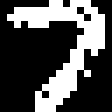

In [129]:
decode(v̄ₒ, number_of_rows = number_of_rows, number_of_cols = number_of_cols) |> img -> Gray.(img)

What does the network give back?

In [131]:
let
    do_I_want_to_see_a_movie = true; # set this flag to watch the frames
    if (do_I_want_to_see_a_movie == true)
        for i ∈ 1:number_of_internal_steps
            img = decode(v̄[:,i], number_of_rows = number_of_rows, number_of_cols = number_of_cols);
            display(Gray.(img))
            println("Turn index = $(i)")
            IJulia.clear_output(true) # may not work in VSCode?
            sleep(0.1) # add some delay
        end
    end
end

LoadError: InterruptException: